In [111]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras import backend as K
import tensorflow as tf

from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv')
df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,3/21/20,3/22/20,3/23/20,3/24/20,3/25/20,3/26/20,3/27/20,3/28/20,3/29/20,3/30/20
0,NaN,Afghanistan,33.0000,65.0000,0,0,0,0,0,0,...,24,40,40,74,84,94,110,110,120,170
1,NaN,Albania,41.1533,20.1683,0,0,0,0,0,0,...,76,89,104,123,146,174,186,197,212,223
2,NaN,Algeria,28.0339,1.6596,0,0,0,0,0,0,...,139,201,230,264,302,367,409,454,511,584
3,NaN,Andorra,42.5063,1.5218,0,0,0,0,0,0,...,88,113,133,164,188,224,267,308,334,370
4,NaN,Angola,-11.2027,17.8739,0,0,0,0,0,0,...,2,2,3,3,3,4,4,5,7,7


In [3]:
df = df.groupby(['Country/Region']).sum().reset_index(level=['Country/Region'])
dates = df.columns[4:]

df = df.melt(id_vars=[ 'Country/Region', 'Lat', 'Long'], 
                            value_vars=dates, var_name='Date', value_name='Confirmed')
df['Date'] =pd.to_datetime(df.Date)

df = df[df['Country/Region'] != 'China']
df_c = df

In [4]:
df_c.head()

,Country/Region,Lat,Long,Date,Confirmed
0,Afghanistan,33.0000,65.0000,2020-01-23,0
1,Albania,41.1533,20.1683,2020-01-23,0
2,Algeria,28.0339,1.6596,2020-01-23,0
3,Andorra,42.5063,1.5218,2020-01-23,0
4,Angola,-11.2027,17.8739,2020-01-23,0


In [5]:
df = df.groupby('Date')['Confirmed'].sum().reset_index()
df['Day num'] = np.arange(1, len(df)+1)
df.head()

,Date,Confirmed,Day num
0,2020-01-23,11,1
1,2020-01-24,21,2
2,2020-01-25,28,3
3,2020-01-26,43,4
4,2020-01-27,50,5


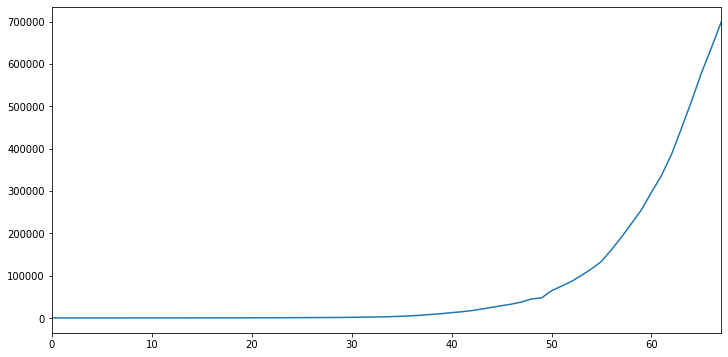

In [6]:
df['Confirmed'].plot(figsize=(12,6))

In [142]:
num_epochs = 100
batch_size = 16
split = 0.9
window = 10

In [143]:
training = split
total = df.shape[0]
train_index = int(total*training)

In [144]:
training_set = df[:train_index]

In [145]:
# sc = MinMaxScaler(feature_range = (0, 1))
sc = StandardScaler(with_mean=True)
training_set_scaled = np.asarray(sc.fit_transform(pd.DataFrame(training_set['Confirmed']).values))

In [146]:

X_train = []
y_train = []
for i in range(window, train_index):
    X_train.append(training_set_scaled[i-window:i, 0])
    y_train.append(training_set_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# Reshaping
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

In [147]:
print(X_train.shape, y_train.shape)

(51, 10, 1) (51,)


In [148]:
X_train[0]

array([[-0.50777767],
       [-0.50762607],
       [-0.50751995],
       [-0.50729255],
       [-0.50718643],
       [-0.50689839],
       [-0.50674679],
       [-0.50653455],
       [-0.50604943],
       [-0.50571591]])

In [149]:
testing_set = df[train_index:]
testing_set = pd.DataFrame(testing_set)
testing_set.head()

,Date,Confirmed,Day num
61,2020-03-24,336454,62
62,2020-03-25,385992,63
63,2020-03-26,447809,64
64,2020-03-27,511394,65
65,2020-03-28,578707,66


In [150]:
real_conf = testing_set['Confirmed'].values

In [151]:
test_set=testing_set['Confirmed']
test_set=pd.DataFrame(test_set)

In [152]:
inputs = df['Confirmed'][len(df) - len(testing_set) - window:].values
# print(inputs)
inputs = inputs.reshape(-1,1)
# print(inputs)
inputs = sc.transform(inputs)
# print(inputs)
X_test = []
for i in range(window, window+(total-train_index)):
    X_test.append(inputs[i-window:i, 0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

In [153]:
# inputs
# total

In [154]:
Y_test = np.asarray(sc.transform(pd.DataFrame(testing_set['Confirmed']).reset_index(drop=True).values))

In [155]:
def root_mean_squared_logarithmic_error(y_true, y_pred):
        return K.sqrt(tf.keras.losses.MSLE(y_pred, y_true))

In [156]:
model = Sequential()

model.add(LSTM(units = 256, return_sequences = True, input_shape=(X_train.shape[1], X_train.shape[2])))
# model.add(Dropout(0.2))

model.add(LSTM(units = 128, return_sequences = True))
# model.add(Dropout(0.2))

# model.add(LSTM(units = 50, return_sequences = True))
# model.add(Dropout(0.2))

model.add(LSTM(units = 128))
# model.add(Dropout(0.2))

# model.add(Dense(units = 256))

model.add(Dense(units = 1, activation="relu"))

model.compile(optimizer = 'adam', loss = root_mean_squared_logarithmic_error)

In [157]:
history = model.fit(X_train, y_train, epochs = num_epochs, batch_size = batch_size, validation_data = (X_test, Y_test))

Train on 51 samples, validate on 7 samples
Epoch 1/100
51/51 [==============================] - 2s 35ms/step - loss: 0.2070 - val_loss: 1.3981
Epoch 2/100
51/51 [==============================] - 0s 4ms/step - loss: 0.1743 - val_loss: 0.5047
Epoch 3/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0911 - val_loss: 0.1829
Epoch 4/100
51/51 [==============================] - 0s 4ms/step - loss: 0.1103 - val_loss: 0.1919
Epoch 5/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0912 - val_loss: 0.3538
Epoch 6/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0349 - val_loss: 0.6739
Epoch 7/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0340 - val_loss: 0.6975
Epoch 8/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0484 - val_loss: 0.6040
Epoch 9/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0293 - val_loss: 0.6237
Epoch 10/100
51/51 [==============================] - 0s 6ms/step

51/51 [==============================] - 0s 4ms/step - loss: 0.0061 - val_loss: 0.3145
Epoch 83/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0059 - val_loss: 0.3012
Epoch 84/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0091 - val_loss: 0.3281
Epoch 85/100
51/51 [==============================] - 0s 5ms/step - loss: 0.0114 - val_loss: 0.3114
Epoch 86/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0085 - val_loss: 0.2671
Epoch 87/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0074 - val_loss: 0.3181
Epoch 88/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0146 - val_loss: 0.3067
Epoch 89/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0080 - val_loss: 0.2594
Epoch 90/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0122 - val_loss: 0.3145
Epoch 91/100
51/51 [==============================] - 0s 4ms/step - loss: 0.0065 - val_loss: 0.3359
Epoch 92/100


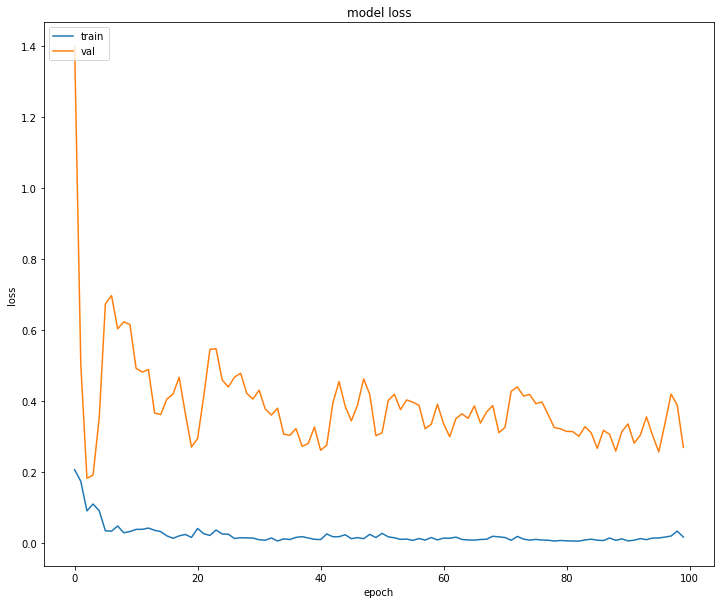

In [158]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')

plt.show()

In [159]:
predicted_conf = model.predict(X_test)

In [160]:
# predicted_conf=pd.DataFrame(predicted_conf)
X_test[0]

array([[0.63093135],
       [0.80264806],
       [1.0162517 ],
       [1.25127634],
       [1.51922838],
       [1.93802189],
       [2.38434586],
       [2.87410307],
       [3.36569464],
       [3.99057245]])

In [161]:
predicted_conf
# X_test
# X_train
# real_conf

array([[4.5749397],
       [4.8715897],
       [5.096018 ],
       [5.261241 ],
       [5.3811865],
       [5.467706 ],
       [5.528118 ]], dtype=float32)

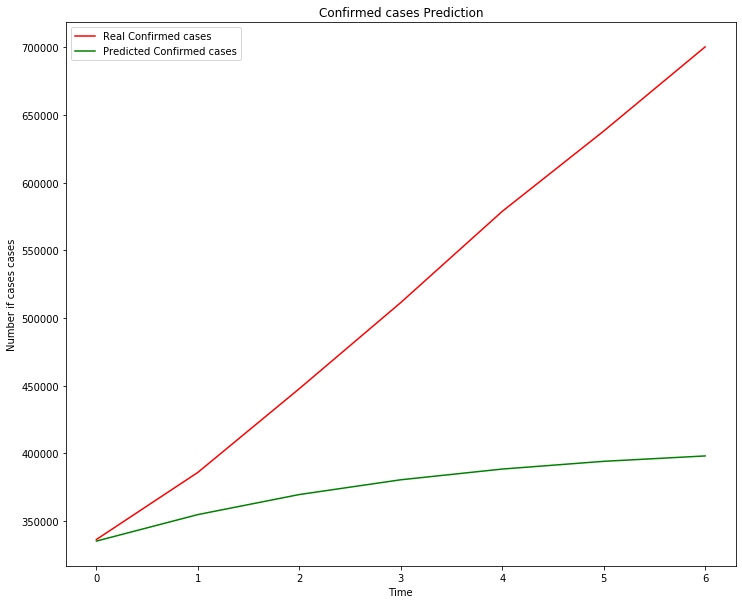

In [162]:
plt.rcParams['figure.figsize'] = [12, 10]
plt.plot(real_conf, color = 'red', label = 'Real Confirmed cases')
plt.plot(sc.inverse_transform(predicted_conf), color = 'green', label = 'Predicted Confirmed cases')
plt.title('Confirmed cases Prediction')
plt.xlabel('Time')
plt.ylabel('Number if cases cases')
plt.legend()
plt.show()